# Train Duration Experiment Analysis
We ran experiments fine-tuning on varying numbers of audio samples from the Buckeye train split and evaluated those models on the Buckeye test split. 
These experiments are targeted at understanding how increasing the amount of data used to train the model affects performance.  Data samples are selected to maintain 50/50 gender split from speakers, with the exception of the models trained on 20000 samples, as there are 18782 audio samples in our train split of Buckeye, but they are not split equally between male and female speakers. Experiments using 20000 samples actually use all 8252 samples from female speakers in the train set, but randomly select 10000 samples from male speakers for a total of 18252 samples. 

For each number of train data samples, 5 models are trained to vary train data selection (`train_seed`) without varying other hyperparameters. Before these models were trained, simple grid search hyperparameter tuning was done to select reasonable hyperparameters for fine-tuning with the target number of samples. 

In [1]:
import json
from pathlib import Path
import re

import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

sns.color_palette("colorblind")
font = {"size": 16}
matplotlib.rc("font", **font)

# Must have paths 
MODEL_DIR = Path("../data/models")
AGGREGATE_METRICS_DIR  = Path("../data/evaluation_results/aggregate_metrics")
DETAILED_PRED_DIR = Path("../data/evaluation_results/detailed_predictions")

DURATION_FEMALE_KEY = "train_duration_female_examples"
DURATION_MALE_KEY = "train_duration_male_examples"
NUM_SAMPLES_FEMALE_KEY = "train_num_female_examples"
NUM_SAMPLES_MALE_KEY = "train_num_male_examples"


In [2]:
# Find models and read into dataframe
model_info = []
for model in MODEL_DIR.glob("train_duration_[0-9]*_samples_[1-5]"):
    model_identifier = model.name
    number_samples = int(model.name.split("_")[2])
    train_summary = json.loads((model / "final_evaluation.json").read_text())
    duration_female = train_summary[DURATION_FEMALE_KEY]
    duration_male = train_summary[DURATION_MALE_KEY]
    num_female_samples = train_summary[NUM_SAMPLES_FEMALE_KEY]
    num_male_samples = train_summary[NUM_SAMPLES_MALE_KEY]
    total_duration = duration_female + duration_male 
    total_samples = num_female_samples + num_male_samples
    model_info.append({
        "model_id":model_identifier, 
        "num_train_samples_specified": number_samples, 
        "actual_num_samples": total_samples, 
        "actual_num_samples_category": str(total_samples),
        DURATION_FEMALE_KEY: duration_female, 
        DURATION_MALE_KEY: duration_male,
        "total_train_duration": total_duration,
    })

model_info_df = pd.DataFrame.from_records(model_info)


In [3]:
print("Model train info dataframe snippet")
print(model_info_df.shape)
print(model_info_df.head())

Model train info dataframe snippet
(45, 7)
                         model_id  num_train_samples_specified  \
0    train_duration_200_samples_3                          200   
1    train_duration_100_samples_1                          100   
2    train_duration_800_samples_5                          800   
3  train_duration_20000_samples_4                        20000   
4  train_duration_12800_samples_3                        12800   

   actual_num_samples actual_num_samples_category  \
0                 200                         200   
1                 100                         100   
2                 800                         800   
3               18252                       18252   
4               12800                       12800   

   train_duration_female_examples  train_duration_male_examples  \
0                      272.881009                    245.634890   
1                      111.668817                    117.602176   
2                     1202.457098       

In [4]:
# Read in evaluation metrics dataframes 
metrics_dfs = []
for eval_metrics_csv in AGGREGATE_METRICS_DIR.glob("train_duration_[0-9]*_eval.csv"):
    # Skip hyperparam tuning evaluations
    if "hyperparam" not in eval_metrics_csv.name: 
        metrics_dfs.append(pd.read_csv(eval_metrics_csv))

eval_metrics_df = pd.concat(metrics_dfs)
eval_metrics_df["model_id"] = eval_metrics_df["model"].apply(lambda x: Path(x).parent.name)

print("Metrics dataframe snippet")
print(eval_metrics_df.shape)
print(eval_metrics_df.head())

Metrics dataframe snippet
(45, 5)
                                               model  mean_phone_error_rate  \
0  data/models/train_duration_800_samples_1/wav2v...               1.011883   
1  data/models/train_duration_800_samples_2/wav2v...               0.975922   
2  data/models/train_duration_800_samples_3/wav2v...               1.082081   
3  data/models/train_duration_800_samples_4/wav2v...               1.082348   
4  data/models/train_duration_800_samples_5/wav2v...               0.970986   

   mean_phone_feature_error_rate  mean_feature_error_rate  \
0                      27.363154                 0.116760   
1                      28.632441                 0.074382   
2                      25.867190                 0.351435   
3                      25.999294                 0.147882   
4                      28.780288                 0.115063   

                       model_id  
0  train_duration_800_samples_1  
1  train_duration_800_samples_2  
2  train_duration_800_

In [5]:
train_analysis_df = pd.merge(model_info_df, eval_metrics_df, on="model_id")
print(train_analysis_df.head())

                         model_id  num_train_samples_specified  \
0    train_duration_200_samples_3                          200   
1    train_duration_100_samples_1                          100   
2    train_duration_800_samples_5                          800   
3  train_duration_20000_samples_4                        20000   
4  train_duration_12800_samples_3                        12800   

   actual_num_samples actual_num_samples_category  \
0                 200                         200   
1                 100                         100   
2                 800                         800   
3               18252                       18252   
4               12800                       12800   

   train_duration_female_examples  train_duration_male_examples  \
0                      272.881009                    245.634890   
1                      111.668817                    117.602176   
2                     1202.457098                   1058.659012   
3               

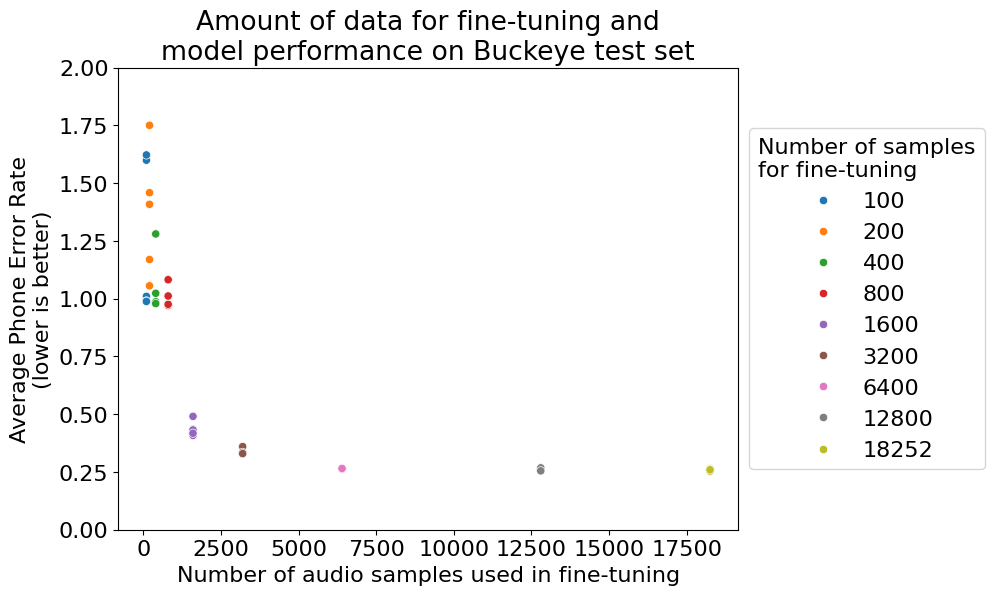

In [6]:
plt.figure(figsize=(8, 6))
g = sns.scatterplot(data=train_analysis_df, x="actual_num_samples", y="mean_phone_error_rate", hue="actual_num_samples_category", 
    hue_order=["100", "200", "400", "800", "1600", "3200", "6400", "12800", "18252"])
g.set_title("Amount of data for fine-tuning and\nmodel performance on Buckeye test set")
g.set_ylabel("Average Phone Error Rate\n(lower is better)")
g.set_xlabel("Number of audio samples used in fine-tuning")
g.set_ylim(0, 2)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), title="Number of samples\nfor fine-tuning")


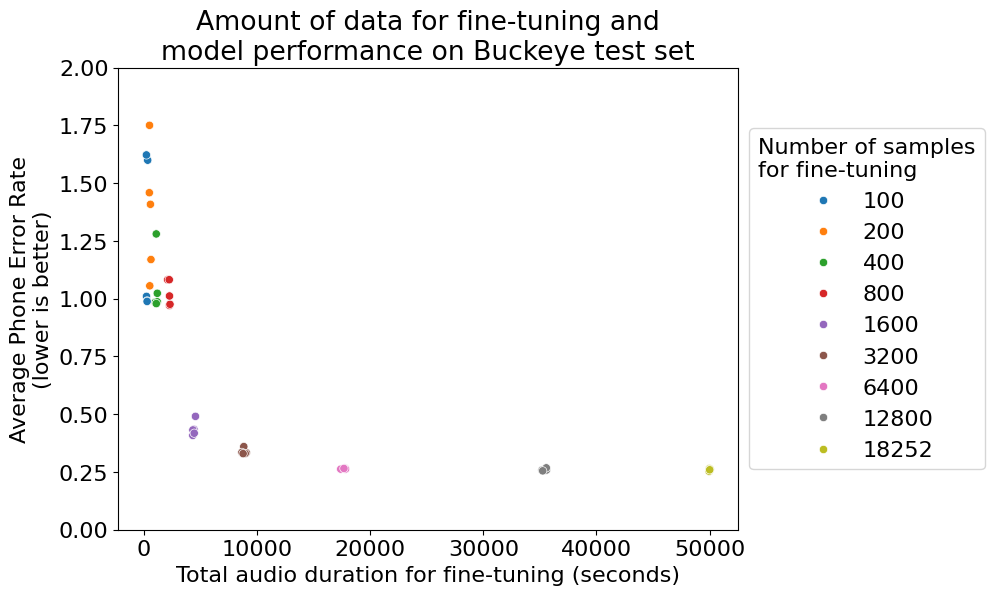

In [7]:
plt.figure(figsize=(8, 6))
g = sns.scatterplot(data=train_analysis_df, x="total_train_duration", y="mean_phone_error_rate", hue="actual_num_samples_category", 
    hue_order=["100", "200", "400", "800", "1600", "3200", "6400", "12800", "18252"])
g.set_title("Amount of data for fine-tuning and\nmodel performance on Buckeye test set")
g.set_ylabel("Average Phone Error Rate\n(lower is better)")
g.set_xlabel("Total audio duration for fine-tuning (seconds)")
g.set_ylim(0, 2)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), title="Number of samples\nfor fine-tuning")

Text(0.5, 0, 'Number of audio samples used in fine-tuning')

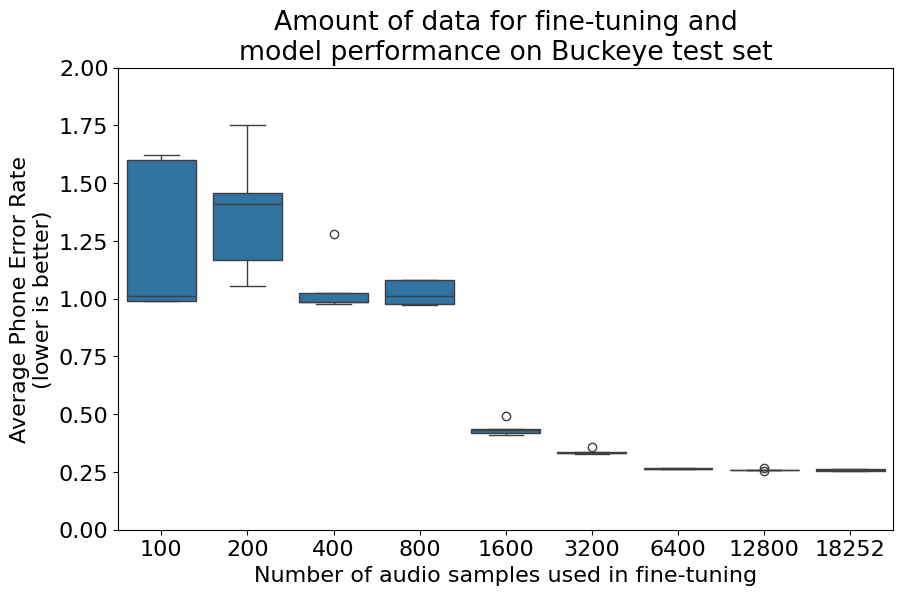

In [13]:
plt.figure(figsize=(10, 6))
g = sns.boxplot(data=train_analysis_df, x="actual_num_samples_category", y="mean_phone_error_rate", 
    order=["100", "200", "400", "800", "1600", "3200", "6400", "12800", "18252"])
g.set_ylim(0, 2)
g.set_title("Amount of data for fine-tuning and\nmodel performance on Buckeye test set")
g.set_ylabel("Average Phone Error Rate\n(lower is better)")
g.set_xlabel("Number of audio samples used in fine-tuning")